In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv


In [58]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

In [41]:
print('CPU: {}'.format(len(tf.config.list_physical_devices('CPU'))))
print('GPU: {}'.format(len(tf.config.list_physical_devices('GPU'))))

CPU: 1
GPU: 1


In [42]:
data = pd.read_csv('/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
data.shape

(35887, 3)

**Veri setine ilk bakış**.

In [43]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [44]:
data["Usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

Veri Ön İşleme Kısmı

In [45]:
trainData = data[data.Usage == "Training"] #Sadece eğitim verilerini trainData olarak tanımladık.

In [46]:
trainLabelsFlat = trainData["emotion"].values.ravel()
trainLabelsCount = np.unique(trainLabelsFlat).shape[0]

In [47]:
#Train verileri dataframe'in içinde bize tablo olarak verilmiştir. Boşluklara göre bölerek her bir footoğrafa ait pixel değerini listeye atıyorum.
trainPixel = trainData.pixels.str.split(" ").tolist()

trainPixel = pd.DataFrame(data = trainPixel, dtype = int)
trainImages = trainPixel.values
trainImages = trainImages.astype(np.float)

In [48]:
def show(img):
    showImg = img.reshape(48,48)
    
    plt.axis("off")
    plt.imshow(showImg, cmap = 'gray')

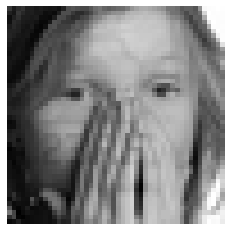

In [49]:
#Fonksiyonumuzu deneyelim
show(trainImages[45])

In [50]:
#Verilerin her birine düşen sınıfı yani eğitim işlemi boyutunu alıyoruz.
def dense_to_one_hot(labelsDense, numClasses):
    numLabels = labelsDense.shape[0]
    indexOffset = np.arange(numLabels) * numClasses
    labelsOneHot = np.zeros((numLabels, numClasses))
    labelsOneHot.flat[indexOffset + labelsDense.ravel()] = 1
    return labelsOneHot

In [51]:
y_train = dense_to_one_hot(trainLabelsFlat,trainLabelsCount)
y_train = y_train.astype(np.uint8)

In [52]:
testData = data[data.Usage == 'PublicTest']
testPixels = testData.pixels.str.split(" ").tolist()

testPixels = pd.DataFrame(data = testPixels, dtype = int)
testImages = testPixels.values
testImages = testImages.astype(np.float)

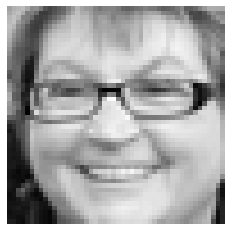

In [53]:
show(testImages[100])

In [54]:
testLabelsFlat = testData["emotion"].values.ravel()
testLabelsCount = np.unique(testLabelsFlat).shape[0]

y_test = dense_to_one_hot(testLabelsFlat,testLabelsCount)
y_test = y_test.astype(np.uint8)

print(y_test.shape)

(3589, 7)


In [68]:
from tensorflow.keras import optimizers

In [69]:
model = Sequential()

#1. katman
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer = "he_normal", input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

#2. katman
model.add(Conv2D(64,3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = 2))
model.add(Dropout(0.5))

#3. katman
model.add(Conv2D(64,3))
model.add(BatchNormalization())
model.add(Activation('relu'))

#4. katman
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation('relu'))
#5. katman
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation('relu'))

#6. katman
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = 2))
model.add(Dropout(0.6))


#Bağlantı katmanı
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

#Çıkış Katmanı
model.add(Dense(7))
model.add(Activation("softmax"))

opt = optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam')

model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ["accuracy"])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_49 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
activation_42 (Activation)   (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_50 (Batc (None, 44, 44, 64)        256       
_________________________________________________________________
activation_43 (Activation)   (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 22, 22, 64)       

In [60]:
x_train = trainImages.reshape(-1, 48 , 48 ,1)
x_test = testImages.reshape(-1, 48, 48, 1)

In [70]:
epochs = 100
batchSize = 32
hist = model.fit(x_train, y_train,
                epochs = epochs, shuffle = True,
                batch_size = batchSize, validation_data = (x_test, y_test), verbose = 2)

Epoch 1/100
898/898 - 12s - loss: 1.8177 - accuracy: 0.3042 - val_loss: 1.4906 - val_accuracy: 0.4177
Epoch 2/100
898/898 - 9s - loss: 1.4994 - accuracy: 0.4148 - val_loss: 1.3584 - val_accuracy: 0.4723
Epoch 3/100
898/898 - 9s - loss: 1.3896 - accuracy: 0.4647 - val_loss: 1.3245 - val_accuracy: 0.4831
Epoch 4/100
898/898 - 9s - loss: 1.3293 - accuracy: 0.4873 - val_loss: 1.4262 - val_accuracy: 0.4656
Epoch 5/100
898/898 - 9s - loss: 1.2874 - accuracy: 0.5061 - val_loss: 1.2669 - val_accuracy: 0.5054
Epoch 6/100
898/898 - 9s - loss: 1.2545 - accuracy: 0.5226 - val_loss: 1.1981 - val_accuracy: 0.5364
Epoch 7/100
898/898 - 9s - loss: 1.2237 - accuracy: 0.5315 - val_loss: 1.2131 - val_accuracy: 0.5411
Epoch 8/100
898/898 - 9s - loss: 1.1950 - accuracy: 0.5471 - val_loss: 1.1424 - val_accuracy: 0.5612
Epoch 9/100
898/898 - 9s - loss: 1.1823 - accuracy: 0.5507 - val_loss: 1.1530 - val_accuracy: 0.5578
Epoch 10/100
898/898 - 9s - loss: 1.1678 - accuracy: 0.5604 - val_loss: 1.1238 - val_accur